In [1]:
# Use python 3.10 and tensforflow 2.10 for gpu acceleration
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.mixed_precision import set_global_policy
from keras.regularizers import l2
import deeplake
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from sklearn.model_selection import train_test_split
import albumentations as album

set_global_policy('mixed_float16')

c:\Users\omayh\anaconda3\envs\.venv\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.0) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
# Import the COCO-Text dataset
# https://datasets.activeloop.ai/docs/ml/datasets/coco-text-dataset/
ds_train = deeplake.load("hub://activeloop/coco-text-train")

# summarize it
ds_train.summary()

/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/coco-text-train



\

hub://activeloop/coco-text-train loaded successfully.



Dataset(path='hub://activeloop/coco-text-train', read_only=True, tensors=['images', 'images_meta', 'masks', 'boxes', 'areas', 'classes', 'languages', 'legibilities', 'utf8_strings'])

    tensor        htype                  shape                 dtype  compression
   -------       -------                -------               -------  ------- 
    images        image      (43686, 102:640, 120:640, 1:3)    uint8    jpeg   
 images_meta      json                 (43686, 1)               str     None   
    masks      binary_mask  (43686, 102:640, 120:640, 0:208)   bool      lz4   
    boxes         bbox             (43686, 0:208, 4)          float32   None   
    areas        generic             (43686, 0:208)           uint32    None   
   classes     class_label           (43686, 0:208)           uint32    None   
  languages    class_label           (43686, 0:208)           uint32    None   
 legibilities  class_label           (43686, 0:208)           uint32    None   
 utf8_strings 

In [ ]:
# Download the database images from deeplake api
images = ds_train.images.numpy(aslist=True)

#save the raw numpy images array to local storage to load it a bit faster next time
#np.savez("data_storage/raw_images_np", *images)

In [2]:
# Load the raw image numpy array from local storage if already downloaded
loaded_data = np.load("data_storage/raw_images_np.npz")
images = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]
print(images[200].shape)

(640, 549, 3)


In [ ]:
# view info about loaded numpy images
print(images[0].shape)
plt.imshow(images[0])
plt.axis('off')
plt.show()

In [ ]:
# check the min sizes of the images
min_size_x = 640
min_size_y = 640

for elem in images:
    if elem.shape[0] < min_size_x:
        min_size_x = elem.shape[0]
    if elem.shape[1] < min_size_y:
        min_size_y = elem.shape[1]

print(min_size_x)
print(min_size_y)

In [4]:
# function pad all image arrays to same size
def pad_image(image, target=(640,640)):
    pad_height = max(target[0] - image.shape[0], 0)  # Padding for height
    pad_width = max(target[1] - image.shape[1], 0)  # Padding for width

    padding = ((0, pad_height), (0, pad_width), (0, 0)) if image.ndim == 3 else ((0, pad_height), (0, pad_width))

    padded_image = np.pad(image, padding, mode='constant', constant_values=0)
    return padded_image

In [5]:
# load other data
boxes = ds_train.boxes.numpy(aslist=True)
classes = ds_train.classes.numpy(aslist=True)
languages = ds_train.languages.numpy(aslist=True)
legibilities = ds_train.legibilities.numpy(aslist=True)

In [ ]:
def plot_image_with_bbox(image, bbox):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Extract bounding box coordinates
    x, y, width, height = bbox
    
    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.show()

In [7]:
# plot a boundary box on image as example
print(images[200].shape)
plot_image_with_bbox(pad_image(images[200]), boxes[200][0])

(640, 549, 3)


NameError: name 'plot_image_with_bbox' is not defined

In [6]:
import random

# get the examples with only one bounding box or none
single_bbox_indices = [i for i, arr in enumerate(boxes) if len(arr) > 0]
print(len(single_bbox_indices))

no_bbox_indices = [i for i, arr in enumerate(boxes) if len(arr) in [0]]
no_bbox_indices = no_bbox_indices[:1000]
print(len(no_bbox_indices))

combined_bbox_indices = single_bbox_indices + no_bbox_indices
print(len(combined_bbox_indices))
random.shuffle(single_bbox_indices)

# get the examples that only have legible text
legible_texts_indices = [i for i, arr in enumerate(legibilities) if 0 not in arr]
print(len(legible_texts_indices))

# get the example that only have english text
english_texts_indices = [i for i, arr in enumerate(languages) if 1 not in arr]
print(len(english_texts_indices))

19039
1000
20039
27449
41326


In [7]:
# get the list with intersecting indices of all three filters
set_single_bbox = set(single_bbox_indices)
set_comb_bbox = set(combined_bbox_indices)
set_legible_texts = set(legible_texts_indices)
set_english_texts = set(english_texts_indices)

# Find the intersection
filtered_indices = set_comb_bbox & set_legible_texts #& set_english_texts

filtered_indices_list = list(filtered_indices)

# to save memory, cut the training examples to 10k
filtered_indices_list = filtered_indices_list[0:6000]
print(len(filtered_indices_list))

3802


In [8]:
# create the new lists according to the filter
single_bbox = [boxes[val] for val in filtered_indices_list]
print(len(single_bbox))


3802


In [9]:
# save the bounding boxes array
np.savez("data_storage/bounding_boxes_np", *single_bbox)

In [2]:
# load the bounding boxes array
loaded_data = np.load("data_storage/bounding_boxes_np.npz")
single_bbox = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]

In [10]:
print(len(single_bbox))

3802


In [11]:
# create the filtered list array
filtered_images = [images[val] for val in filtered_indices_list]

In [12]:
# save filtered images
np.savez("data_storage/filtered_images_np", *filtered_images)

In [14]:
# load filtered images
loaded_data = np.load("data_storage/filtered_images_np.npz")
filtered_images = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]

In [13]:
# add padding to all the images
for i in range(len(filtered_images)):
    filtered_images[i] = pad_image(filtered_images[i])

In [14]:
# Memory saving checkpoint
# save the padded images
np.savez("data_storage/padded_images_np", *filtered_images)

In [ ]:
# load the padded images
loaded_data = np.load("data_storage/padded_images_np.npz")
filtered_images = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]

In [15]:
# function to make sure every image is in rgb format
def convert_to_rgb(image):
    if image.shape[-1] == 1:
        image = np.repeat(image, 3, axis=-1)

    return image

In [ ]:
test = convert_to_rgb(filtered_images[5])
print(filtered_images[5].shape)
print(test.shape)

In [16]:
# convert every image to rgb
fixed_images = [convert_to_rgb(img) for img in filtered_images]

In [17]:
# scale the image rgb values from 0 to 1
scaled_images = [image.astype(np.float16) / 255.0 for image in fixed_images]

In [18]:
# Memory saving checkpoint
# save the scaled images
np.savez("data_storage/scaled_images_np", *scaled_images)

In [3]:
# load the scaled images
loaded_data = np.load("data_storage/scaled_images_np.npz")
scaled_images = [loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))]

In [ ]:
print(scaled_images[5][0][0])

In [4]:
images_array = np.array(scaled_images)

In [5]:
print(images_array.shape)

(3802, 640, 640, 3)


In [6]:
# Memory saving checkpoint
# save the images array
np.savez("data_storage/images_array_np", images_array)

In [4]:
# load the images array
loaded_data = np.load("data_storage/images_array_np.npz")
images_array = np.array([loaded_data[f'arr_{i}'] for i in range(len(loaded_data.files))])

In [5]:
# fix the leading extra dimension
images_array = np.squeeze(images_array, axis=(0))

In [7]:
def resize_images_in_batches(images, new_size=(320, 320), batch_size=100):
    num_images = images.shape[0]
    resized_images = np.empty((num_images, *new_size, 3), dtype=np.float32)  # Pre-allocate array
    
    for start in range(0, num_images, batch_size):
        end = start + batch_size
        batch_images = images[start:end]
        batch_images_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        resized_batch = tf.image.resize(batch_images_tensor, new_size).numpy() 
        resized_images[start:end] = resized_batch 
        
    return resized_images


images_array = resize_images_in_batches(images_array, new_size=(320, 320), batch_size=100)

In [7]:
# remove all the bounding boxes with negative value or bigger than the image itself
to_remove = []
for i, elem in enumerate(single_bbox):
    if len(elem) == 0:
        continue
    if elem[0][0] + elem[0][2] > 640:
        to_remove.append(i)
    if elem[0][1] + elem[0][3] > 640:
        to_remove.append(i)
    for k in elem[0]:
        if k < 0:
            to_remove.append(i)
        if k >= 640:
            to_remove.append(i)
        


# remove duplicate indices
to_remove = list(set(to_remove))
to_remove.sort(reverse=True)

print(to_remove)

images_array = np.delete(images_array, to_remove, axis=0)

for index in to_remove:
    single_bbox.pop(index)

[3333, 3301, 3252, 3195, 3176, 3157, 3135, 3128, 3010, 2982, 2885, 2856, 2827, 2798, 2746, 2742, 2722, 2678, 2642, 2639, 2573, 2539, 2469, 2450, 2420, 2350, 2327, 2264, 2211, 2209, 2173, 2139, 2093, 2091, 2041, 1982, 1937, 1891, 1709, 1676, 1647, 1644, 1619, 1586, 1492, 1319, 1257, 1218, 1160, 982, 857, 743, 641, 490, 257, 112, 56]


In [8]:
# convert to grayscale
def rgb_to_grayscale(images):
    # Apply the luminosity method
    return np.dot(images[...,:3], [0.2989, 0.5870, 0.1140])

# Convert your images
images_array = rgb_to_grayscale(images_array)
images_array = np.expand_dims(images_array, -1)

In [9]:
print(images_array.shape)
print(len(single_bbox))

(3342, 320, 320, 1)
3342


In [10]:
print(single_bbox[5])
print(len(single_bbox[5]))

[[208.5 127.8  13.7  13.7]
 [195.6 231.5  34.4  19.6]
 [503.1 121.4  15.9  18.2]
 [504.6 184.4  26.6  23.3]
 [507.9 201.4  27.   24.8]]
5


In [11]:
# for images with multiple bounding boxes, paint the texts with black except one of them
def mask_bounding_boxes(images, bboxes):
   
    for i, bbox in enumerate(bboxes):
        if len(bbox) <= 1:
            continue
        
        for box in bbox[1:]:
            x = int(box[0] / 2)
            y = int(box[1] / 2)
            w = int(box[2] / 2)
            h = int(box[3] / 2)

            x_end = min(x + w, images.shape[2])
            y_end = min(y + h, images.shape[1])
            
            
            images[i, y:y_end, x:x_end, :] = 0
            
    return images

In [12]:
images_array = mask_bounding_boxes(images_array, single_bbox)

TypeError: slice indices must be integers or None or have an __index__ method

[[346.3 407.1  19.5   8.5]
 [318.5 406.4  22.5   8.9]
 [287.2 406.3  26.5   9.3]
 [274.9 404.8   8.9  10.5]]


TypeError: cannot unpack non-iterable numpy.float32 object

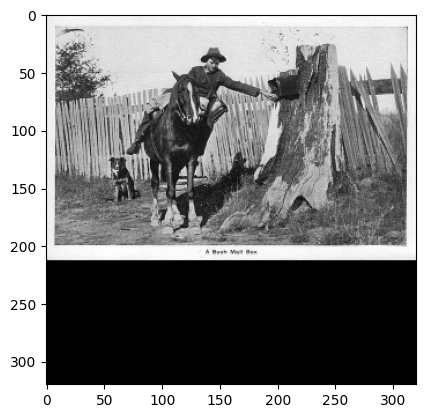

: 

In [32]:

image_index = 18

print(boxes_array[image_index])

fig, ax = plt.subplots(1)
# visualize the image
plt.imshow(images_array[image_index][:, :, 0], cmap='gray')

x = int(boxes_array[image_index][1] * 320.0)
y = int(boxes_array[image_index][2] * 320.0)
w = int(boxes_array[image_index][3] * 320.0)
h = int(boxes_array[image_index][4] * 320.0)
rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.axis('off')  # Hide the axis
plt.show()

In [9]:
# add zeroes for no bounding boxes
boxes = [[np.concatenate(([1], box[0]))] if len(box) == 1 else [[0, 0, 0, 0, 0]] for box in single_bbox]

In [ ]:
print(boxes_array[4])

[1.         0.34328125 0.29234376 0.07375    0.015     ]


In [45]:
boxes_array = np.array(boxes)
boxes_array = np.squeeze(boxes_array, axis=1)

In [46]:
# Only normalize columns 1 through 4 (x, y, width, height)
boxes_array[:, 1:] = boxes_array[:, 1:] / 640.0

In [47]:
# see the shapes of images and bounding boxes
print(images_array.shape)
print(boxes_array.shape)

(3342, 240, 240, 1)
(3342, 5)


In [13]:
images_train, images_test, boxes_train, boxes_test = train_test_split(
    images_array, boxes_array, test_size=0.1, random_state=42)

In [14]:
images_train, images_val, boxes_train, boxes_val = train_test_split(
    images_train, boxes_train, test_size=0.25, random_state=42)

In [15]:
print(images_train.shape)
print(images_val.shape)

(1242, 240, 240, 1)
(415, 240, 240, 1)


In [16]:
def load_data(images, labels):
    for image, label in zip(images, labels):
        yield image, label

In [ ]:
# DIDNT WORK FOR ME DONT RUN THIS
# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, False)
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [17]:
# Batch the dataset

train_dataset = tf.data.Dataset.from_generator(
    lambda: load_data(images_train, boxes_train),
    output_types=(images_train.dtype, boxes_train.dtype),
    output_shapes=([240, 240, 1], [5])
)

validation_dataset = tf.data.Dataset.from_generator(
    lambda: load_data(images_val, boxes_val),
    output_types=(images_val.dtype, boxes_val.dtype),
    output_shapes=([240, 240, 1], [5])
)

BATCH_SIZE = 32

# Batch the datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# custom output layer
class CustomOutputLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomOutputLayer, self).__init__(**kwargs)

    def call(self, inputs):
        confidence = tf.sigmoid(inputs[:, 0:1])
        
        bbox_coordinates = inputs[:, 1:]
        
        return tf.concat([confidence, bbox_coordinates], axis=-1)

In [4]:
# create the cnn model
model = tf.keras.Sequential([
    # First convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(320, 320, 1), kernel_regularizer=l2(0.00001)),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.05),

    # Second convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.00001)),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.1),

    # Third convolutional block
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.00001)),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.15),

    # Fourth convolutional block
    layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.00001)),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.2),

    # Fifth convolutional block
    layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=l2(0.00001)),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    # layers.Dropout(0.25),


    # Flattening the 3D output to 1D
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(1024, activation='relu'),
    # layers.Dropout(0.4),

    # Output layer with 5 units (for the bounding box [confidence, x, y, size_x, size_y])
    layers.Dense(5),
    #CustomOutputLayer()
])

In [22]:
# create custom loss function
def custom_loss(y_true, y_pred):
    # Split the inputs into confidence and bounding box coordinates
    confidence_true, bbox_true = y_true[:, 0], y_true[:, 1:]
    confidence_pred, bbox_pred = y_pred[:, 0], y_pred[:, 1:]

    confidence_loss = tf.keras.losses.binary_crossentropy(confidence_true, confidence_pred)

    bbox_mask = tf.cast(confidence_true > 0, tf.float16)

    bbox_loss = tf.keras.losses.mean_squared_error(bbox_true, bbox_pred) * bbox_mask

    bbox_loss = tf.reduce_sum(bbox_loss) / (tf.reduce_sum(bbox_mask) + tf.keras.backend.epsilon())

    confidence_loss_weight = 2.0
    bbox_loss_weight = 3.0

    total_loss = confidence_loss_weight * confidence_loss + bbox_loss_weight * bbox_loss

    return total_loss

In [23]:
# create custom learning schedule
initial_learning_rate = 0.0001
decay_steps = 1000
decay_rate = 0.96

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)

custom_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [23]:
# compile the model
model.compile(optimizer='adam', loss=custom_loss, metrics='mse')

In [24]:
history = model.fit(
    train_dataset,  # Training data and labels
    epochs=30,  # Number of epochs to train for
    validation_data=validation_dataset  # Validation data and labels
)

Epoch 1/30
39/39 [==============================] - 10s 79ms/step - loss: 5.4934 - mse: 1.1482 - val_loss: 1.5496 - val_mse: 0.0837
Epoch 2/30
39/39 [==============================] - 2s 45ms/step - loss: 1.5324 - mse: 0.0973 - val_loss: 1.5045 - val_mse: 0.0975
Epoch 3/30
39/39 [==============================] - 2s 45ms/step - loss: 1.5203 - mse: 0.0974 - val_loss: 1.5030 - val_mse: 0.0960
Epoch 4/30
39/39 [==============================] - 2s 45ms/step - loss: 1.5139 - mse: 0.0972 - val_loss: 1.5029 - val_mse: 0.0980
Epoch 5/30
39/39 [==============================] - 2s 48ms/step - loss: 1.5090 - mse: 0.0969 - val_loss: 1.5061 - val_mse: 0.0971
Epoch 6/30
39/39 [==============================] - 2s 48ms/step - loss: 1.5031 - mse: 0.0964 - val_loss: 1.5138 - val_mse: 0.0982
Epoch 7/30
39/39 [==============================] - 2s 45ms/step - loss: 1.4975 - mse: 0.0959 - val_loss: 1.5178 - val_mse: 0.0984
Epoch 8/30
39/39 [==============================] - 2s 50ms/step - loss: 1.4838 - 

In [ ]:
# save the trained model
model.save('trained_model/text_recognizer_01.h5')

In [ ]:
# load a saved model
from tensorflow.keras.models import load_model

model = load_model('trained_model/text_recognizer_01.h5')

In [1]:
# test the trained model

test_index = 25

test_image = np.expand_dims(images_test[test_index], axis=0)
predicted_box = model.predict(images_test[test_index])

predicted_box = predicted_box[0] * 200.0
predicted_box[0] = predicted_box[0] / 200.0
#predicted_box[0][3] = predicted_box[0][3] * -1.0
real_box = boxes_test[test_index] * 200

print(predicted_box)
print(real_box)

# print(images_test.shape)
# print(boxes_test.shape)


# Display the original image
plt.imshow(images_test[test_index].astype('float32'))  # Assuming this is already normalized and ready for display

# Create a Rectangle patch for the predicted bounding box
rect = patches.Rectangle((predicted_box[1], predicted_box[2]), predicted_box[3], predicted_box[4], linewidth=1, edgecolor='r', facecolor='none')

# Create a Rectangle patch for the real bounding box 
#rect = patches.Rectangle((real_box[1], real_box[2]), real_box[3], real_box[4], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
plt.gca().add_patch(rect)
plt.show()


NameError: name 'np' is not defined

In [ ]:
# come up with average mse for all the test images
total_mse = 0
for i, image in enumerate(images_test):
  test_image = np.expand_dims(image, axis=0)
  predicted_box = model.predict(test_image)[0]
  real_box = boxes_test[i]
  mse = tf.keras.losses.mean_squared_error(predicted_box, real_box)
  mean = tf.reduce_mean(mse)
  total_mse += mean
  
  
print(total_mse / len(images_test))